# Classical Shadows for Entanglement Entropy

This notebook demonstrates how to use **classical shadows** to estimate 
entanglement entropy in the transverse-field Ising model (TFIM), following  
Huang *et al.*, *Nature Physics* **16**, 1050–1057 (2020),  
DOI: [10.1038/s41567-020-0932-7](https://doi.org/10.1038/s41567-020-0932-7).

- First, we compute exact ground state entanglement entropy as a function of $g/J$.  
- Then, we apply the **Pauli classical shadow scheme** to approximate the same quantity.  
- Finally, we compare exact results and shadow-based estimates.

The goal is to see how well classical shadows capture entanglement near the 
critical point $g/J \approx 1$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Constructing Transverse Field Ising Model (a.k.a TFIM)

We now study the ground state entanglement entropy as a function of the 
transverse field strength $g$ (with $J=1$).  

The Hamiltonian is:
$$
H = - J \sum_{i=1}^{N-1} Z_i Z_{i+1} - g \sum_{i=1}^N X_i,
$$
with $N$ spins in a 1D chain.

- For $g \ll J$: the system is ordered in the $Z$ direction (ferromagnetic phase).  
- For $g \gg J$: the system is disordered and polarized along $X$ (paramagnetic phase).  
- Around $g/J \approx 1$: a **quantum phase transition** occurs.

In [2]:
# Paul matrices
I = np.array([[1,0],[0,1]], dtype=complex)
X = np.array([[0,1],[1,0]], dtype=complex)
Y = np.array([[0,-1j],[1j,0]], dtype=complex)
Z = np.array([[1,0],[0,-1]], dtype=complex)

# op: operator (I, X, Y, Z), site: index of the spin, N: total number of spins
# Returns: operator matrix for the local operator at the specified site
def local_op(op, site, N):
    ops = [I]*N
    ops[site] = op
    return kron_n(ops)

# ops: list of operator matrices
# Returns: Kronecker product of the operators in the list
def kron_n(ops):
    out = np.array([[1]], dtype=complex)
    for op in ops:
        out = np.kron(out, op)
    return out

# N: number of spins, J: coupling strength, g: transverse field, periodic: True/False
# Returns: Ising Hamiltonian matrix H
def tfim_hamiltonian(N, J=1.0, g=1.0, periodic=True):
    H = np.zeros((2**N, 2**N), dtype=complex)

    def zz_coupling(i, j, N): # zz coupling operator for spins i and j
        ops = [I]*N
        ops[i] = Z; ops[j] = Z
        return kron_n(ops)
    
    for i in range(N-1):
        H -= J * zz_coupling(i, i+1, N)
    if periodic and N>2:
        H -= J * zz_coupling(N-1, 0, N)
    for i in range(N):
        H -= g * local_op(X, i, N)
    return H

# H: Hamiltonian matrix
# Returns: density matrix |psi0><psi0| for the ground state of H
def ground_state_rho(H):
    evals, evecs = np.linalg.eigh(H)
    psi0 = evecs[:, np.argmin(evals)]
    return np.outer(psi0, psi0.conj())

# rho: density matrix, keep: list of spins to keep, N: total number of spins
# Returns: reduced density matrix after tracing out the specified spins
def partial_trace(rho, keep, N):
    keep = sorted(keep)
    all_idx = list(range(N))
    trace_out = [i for i in all_idx if i not in keep]
    dims = [2]*N
    d_keep = 2**len(keep); d_tr = 2**(N-len(keep))
    rho_t = rho.reshape(dims + dims)
    perm = keep + trace_out + [i+N for i in keep] + [i+N for i in trace_out]
    rho_p = np.transpose(rho_t, axes=perm).reshape(d_keep, d_tr, d_keep, d_tr)
    rho_keep = np.einsum('abcb->ac', rho_p)
    return rho_keep

# rho: density matrix, type: 'vN' for von Neumann entropy or 'R2' for Renyi-2 entropy
# Returns: entropy value (von Neumann or Renyi-2)
def entropy(rho, type ='vN'):
    evals = np.linalg.eigvalsh(rho)
    evals = np.clip(evals.real, 1e-12, 1.0)
    if type == 'R2': return -np.log2(np.sum(evals**2))  # Renyi-2 entropy
    return -np.sum(evals * np.log2(evals))              # von Neumann entropy

We compute the **ground state entanglement entropy** of the one third of the chain, 
$$
S(\rho_A) = - \mathrm{Tr} \big( \rho_A \log \rho_A \big),
$$
where $\rho_A = \mathrm{Tr}_B(|\psi\rangle \langle \psi|)$ is the reduced density matrix 
of the block $A$.

By sweeping $g/J$ for various system sizes $N$, the entanglement entropy 
shows a peak near the critical point, signaling the phase transition.

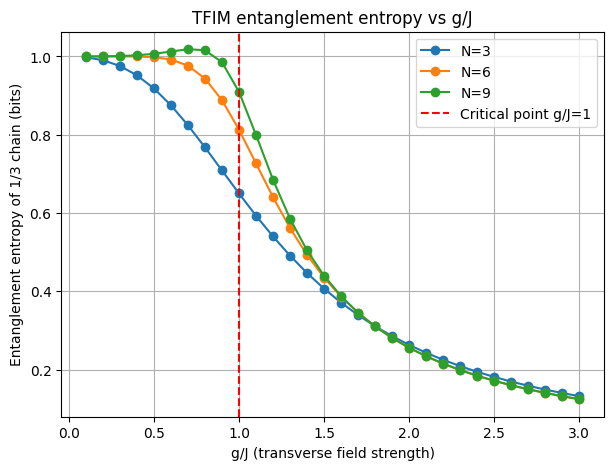

In [3]:
J = 1.0
g_list = np.linspace(0.1, 3.0, 30)   # sweep transverse field strength
N_list = [3, 6, 9]

plt.figure(figsize=(7,5))

for N in N_list:
    block = list(range(N//3))  # one third of the chain
    S_list = []                # entanglement entropy list for this N
    for g in g_list:
        Ham = tfim_hamiltonian(N, J=J, g=g, periodic=True)
        rho = ground_state_rho(Ham)             # ground state density matrix
        rhoA = partial_trace(rho, block, N)   # reduced density matrix
        S = entropy(rhoA)
        S_list.append(S)
    
    plt.plot(g_list, S_list, marker='o', label=f"N={N}")

# critical point g/J=1
plt.axvline(x=1.0, color='r', linestyle='--', label="Critical point g/J=1")

plt.xlabel("g/J (transverse field strength)")
plt.ylabel("Entanglement entropy of 1/3 chain (bits)")
plt.title("TFIM entanglement entropy vs g/J")
plt.legend()
plt.grid(True)
plt.show()

### (Optional Info) Exact Rényi-2 entropy via Toeplitz (free-fermion method)

For the 1D Transverse-Field Ising Model (TFIM), the ground state is a *Gaussian fermionic state* after Jordan–Wigner and Bogoliubov transformation.  
As a consequence, the reduced density matrix of a contiguous block of spins can be fully characterized by its **two-point correlation matrix**.  

Specifically, for a block of length $L$, one constructs the $L \times L$ Toeplitz matrix

$$
G_{ij} = g_{i-j}, \quad 
g_\ell = \frac{1}{N} \sum_k f(k)\, e^{-i k \ell},
$$

where $f(k)$ is the Bogoliubov factor

$$
f(k) = \frac{g - J \cos k + i J \sin k}{\sqrt{(g - J \cos k)^2 + (J \sin k)^2}} .
$$

The singular values $\{ s_m \}$ of $G$ determine the entanglement spectrum of the block.  
The Rényi-2 entropy then follows as

$$
S_2 = - \sum_m \log_2\!\left( \frac{1 + s_m^2}{2} \right).
$$

This approach is exact for arbitrary system size $N$ and block size $L$, and is computationally efficient compared to exact diagonalization (which scales as $2^N$).  
It is widely used in the study of entanglement entropy in free fermionic systems.

**References**:  
- I. Peschel, *Calculation of reduced density matrices from correlation functions*, J. Phys. A **36**, L205 (2003).  
- P. Calabrese and J. Cardy, *Entanglement entropy and quantum field theory*, J. Stat. Mech. P06002 (2004).  

In [4]:
# ---------- Utilities ----------
def ks_grid(N, sector):
    m = np.arange(N)
    if sector == "pbc":
        return 2*np.pi*m/N
    elif sector == "apbc":
        return 2*np.pi*(m+0.5)/N
    else:
        raise ValueError("sector must be 'pbc' or 'apbc'")

def eps_k(k, J, g):
    a = g - J*np.cos(k)
    b = J*np.sin(k)
    return 2.0*np.sqrt(a*a + b*b)

def bogoliubov_factor(k, J, g):
    # f(k) = (g - J cos k + i J sin k) / sqrt((g - J cos k)^2 + (J sin k)^2)
    denom = np.sqrt((g - J*np.cos(k))**2 + (J*np.sin(k))**2) + 1e-15
    return (g - J*np.cos(k) + 1j*J*np.sin(k)) / denom

def gs_energy_sector(N, J, g, sector):
    k = ks_grid(N, sector)
    return -0.5*np.sum(eps_k(k, J, g))  # 상수항은 섹터별 동일하므로 비교에 무관

def choose_sector(N, J, g):
    e_pbc  = gs_energy_sector(N, J, g, "pbc")
    e_apbc = gs_energy_sector(N, J, g, "apbc")
    return ("pbc" if e_pbc <= e_apbc else "apbc")

def toeplitz_G(N, L, J, g, sector):
    """
    Build the LxL Toeplitz matrix G with entries G_{ij} = g_{i-j},
    where g_l = (1/N) sum_k f(k) e^{-i k l}, f(k)=Bogoliubov factor.
    """
    k = ks_grid(N, sector)
    fk = bogoliubov_factor(k, J, g)           # shape (N,)
    # compute g_l for l in [-(L-1), ..., 0, ..., +(L-1)]
    ls = np.arange(-(L-1), L)                 # (2L-1,)
    phase = np.exp(-1j * np.outer(ls, k))     # (2L-1, N)
    g_l = (phase @ fk) / N                    # (2L-1,)
    # assemble Toeplitz G from g_{i-j}
    I = np.arange(L)[:, None]
    Jidx = np.arange(L)[None, :]
    diff = I - Jidx                           # (L, L) in [-(L-1), ..., +(L-1)]
    # map diff to index in g_l (offset by L-1)
    return g_l[diff + (L-1)]

def entropy_from_G(G, base=2):
    """
    For TFIM/JW Gaussian state:
      singular values s_m of G  ->  p_m = (1 + s_m)/2
      S_vN = sum_m H(p_m)
      S_2  = - sum_m log( (1 + s_m**2)/2 )
    """
    s = np.linalg.svd(G, compute_uv=False)
    s = np.clip(s.real, 0.0, 1.0)
    p = 0.5*(1.0 + s)
    # von Neumann entropy (bits if base=2)
    S_vN = -np.sum( p*np.log(p) + (1-p)*np.log(1-p) ) / np.log(base)
    # Renyi-2 (bits)
    S2 = -np.sum( np.log(0.5*(1.0 + s*s)) ) / np.log(base)
    return S_vN, S2

def tfim_block_entropy(N, L, J=1.0, g=1.0, sector="auto"):
    if sector == "auto":
        sector = choose_sector(N, J, g)
    G = toeplitz_G(N, L, J, g, sector)
    S_vN, S2 = entropy_from_G(G, base=2)
    return S_vN, S2, sector

def estimate_S2(N, J, g, L=None, method="toeplitz"):
    """
    Estimate Rényi-2 entropy S2 for a contiguous block of length L in TFIM ground state.
    N : Number of spins.
    J : Coupling strength.
    g : Transverse field.
    L : Length of the subsystem block (assumed contiguous, starting at site 0). If None, defaults to N//2.
    
    method : {"toeplitz","diag"}
        - "toeplitz": exact free-fermion formula (fast, large N OK).
        - "diag": exact diagonalization + partial trace (small N only).

    Returns: Rényi-2 entropy S2(L) in bits.
    """
    if L is None:
        L = N//2

    if method == "toeplitz":
        # exact via Toeplitz/Gaussian
        _, S2, _ = tfim_block_entropy(N, L, J=J, g=g, sector="auto")
        return float(S2)

    elif method == "diag":
        # exact by diagonalization (small N only)
        H = tfim_hamiltonian(N, J=J, g=g, periodic=True)
        rho = ground_state_rho(H)
        keep = list(range(L))   # contiguous block from site 0
        rhoA = partial_trace(rho, keep=keep, N=N)
        tr2 = np.trace(rhoA @ rhoA).real
        tr2 = float(np.clip(tr2, 1e-12, 1.0))
        return -np.log2(tr2)

    else:
        raise ValueError("method must be 'toeplitz' or 'diag'")

/var/folders/6p/gbsv4n_s33111swtcpfvtn200000gn/T/ipykernel_61095/2827834280.py:59: RuntimeWarning: divide by zero encountered in log
  S_vN = -np.sum( p*np.log(p) + (1-p)*np.log(1-p) ) / np.log(base)
/var/folders/6p/gbsv4n_s33111swtcpfvtn200000gn/T/ipykernel_61095/2827834280.py:59: RuntimeWarning: invalid value encountered in multiply
  S_vN = -np.sum( p*np.log(p) + (1-p)*np.log(1-p) ) / np.log(base)


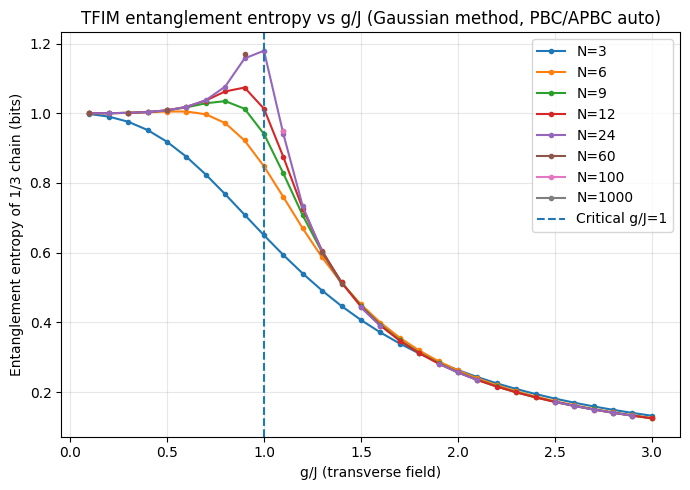

In [ ]:
# ---------- Plot: entanglement entropy vs g/J ----------
J = 1.0
g_list = np.linspace(0.1, 3.0, 30)
N_list = [3, 6, 9, 12, 24, 60, 100, 1000]

plt.figure(figsize=(7,5))
for N in N_list:
    L = N//2
    S_list = []
    for g in g_list:
        S, S2, sec = tfim_block_entropy(N, L, J=J, g=g, sector="auto")  # PBC/APBC 자동 선택
        S_list.append(S)
    plt.plot(g_list, S_list, marker='o', ms=3, label=f"N={N}")

plt.axvline(x=1.0, linestyle='--', label="Critical g/J=1")
plt.xlabel("g/J (transverse field)")
plt.ylabel("Entanglement entropy of 1/3 chain (bits)")
plt.title("TFIM entanglement entropy vs g/J (Gaussian method, PBC/APBC auto)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Classical Shadows — Snapshot construction
- Randomly choose local Pauli bases ($X,Y,Z$).
- Sample measurement outcomes according to Born’s rule.
- Apply inverse channel locally: $\hat{\rho}^{(s)} = \otimes (3\Pi - I)$.

In [6]:
import numpy as np
from itertools import combinations
from tqdm import tqdm

# --- single-qubit constants ---
I2  = np.eye(2, dtype=complex)
H1   = (1/np.sqrt(2)) * np.array([[1, 1],
                                 [1,-1]], dtype=complex)
Sdg = np.array([[1, 0],
                [0,-1j]], dtype=complex)

# Local Pauli rotations: U s.t. measuring Z after U equals measuring in {X,Y,Z}
def rot_to_Z(b):
    if b == 'Z': return I2
    if b == 'X': return H1
    if b == 'Y': return Sdg @ H1
    raise ValueError("basis must be 'X','Y','Z'")

# Projector Π for given basis/outcome bit
def one_qubit_projector(b, bit):
    bit = int(bit)
    if b == 'Z':
        v = np.array([1,0], dtype=complex) if bit == 0 else np.array([0,1], dtype=complex)
    elif b == 'X':
        v = (1/np.sqrt(2)) * (np.array([1, 1], dtype=complex) if bit == 0
                              else np.array([1,-1], dtype=complex))
    elif b == 'Y':
        v = (1/np.sqrt(2)) * (np.array([1, 1j], dtype=complex) if bit == 0
                              else np.array([1,-1j], dtype=complex))
    else:
        raise ValueError("basis must be 'X','Y','Z'")
    return np.outer(v, v.conj())

# Inverse channel (Pauli-6 scheme): M^{-1}(Π) = 3 Π - I
def one_qubit_shadow_estimator(b, bit):
    P = one_qubit_projector(b, bit)
    return 3.0 * P - I2


## Classical Shadows — Subsystem entropy
- Reduce each snapshot $\hat{\rho}^{(s)}$ to subsystem $A$.
- Estimate purity using cross terms:
  $$\widehat{\mathrm{Tr}(\rho_A^2)} = \frac{1}{K(K-1)}\sum_{s\neq t}\mathrm{Tr}(\hat\rho_A^{(s)}\hat\rho_A^{(t)})$$
- Compute Rényi-2 entropy: $S_2(A) = -\log_2(\,\cdot\,)$.

In [ ]:
# --- Statevector-based shadow sampling and S2 estimator ---

# psi: statevector |psi> as a 1D complex array
# bases: list of Pauli bases ('X', 'Y', 'Z') for each
# method: 'fast' for tensor product rotations, 'slow' for one-by-one rotations
# returns: statevector after applying local rotations so Z-measurement = Pauli measurement
def apply_local_rotations_to_psi(psi, bases, method='fast'):    
    """Apply tensor product of local rotations so Z-measurement = Pauli measurement."""
    if method == 'fast':
        N = int(np.log2(psi.size))
        psi_t = psi.reshape([2]*N)  # shape (2,2,...,2)
        for q, b in enumerate(bases):
            U = rot_to_Z(b)                    # (2,2)
            # apply on axis q: psi'[..., a_q, ...] = sum_b U[a_q,b] * psi[..., b, ...]
            psi_t = np.tensordot(psi_t, U.T, axes=([q],[0]))  # result: axes merged at end
            # move the new axis (currently last) back to position q
            axes = list(range(psi_t.ndim))
            axes.insert(q, axes.pop(-1))
            psi_t = np.transpose(psi_t, axes=axes)
        return psi_t.reshape(-1)
    
    # slow method: apply rotations one by one
    U_list = [rot_to_Z(b) for b in bases]   # each 2x2
    U = kron_n(U_list)                      # global 2^N x 2^N
    return U @ psi

# returns: one bitstring outcome from |psi> in random Pauli bases
def sample_outcome_bits_from_psi(psi, bases, rng, method='fast'):
    # fast method: apply tensor product of local rotations
    if method == 'fast':
        psi_rot = apply_local_rotations_to_psi(psi, bases, method='fast')
        probs = np.abs(psi_rot)**2
        probs = np.clip(probs, 0.0, None); probs /= probs.sum()
        N = int(np.log2(probs.size))
        idx = rng.choice(probs.size, p=probs)
        return np.array([(idx >> (N-1-k)) & 1 for k in range(N)], dtype=int)
    
    # slow method: apply rotations one by one
    N = int(np.log2(psi.size))
    psi_rot = apply_local_rotations_to_psi(psi, bases, N)
    probs = np.abs(psi_rot)**2
    probs = np.clip(probs, 0.0, None); probs /= probs.sum()
    idx = rng.choice(probs.size, p=probs)
    return np.array([(idx >> (N-1-k)) & 1 for k in range(N)], dtype=int)

def kron_n(ops):
    out = np.array([[1.0+0j]], dtype=complex)
    for op in ops:
        out = np.kron(out, op)
    return out

def purity_from_shadows_keep_only_psi(psi, keep, shots=1000, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    N = int(np.log2(psi.size))
    opsA = []
    for _ in range(shots):
        bases = rng.choice(np.array(['X','Y','Z']), size=N)
        bits  = sample_outcome_bits_from_psi(psi, bases, rng)
        ops_keep = [one_qubit_shadow_estimator(bases[q], int(bits[q])) for q in keep]
        opsA.append(kron_n(ops_keep))
    # unbiased cross-term estimator
    acc, cnt = 0.0, 0
    for i, j in combinations(range(len(opsA)), 2):
        acc += np.trace(opsA[i] @ opsA[j]).real
        cnt += 1
    pur = acc/cnt if cnt>0 else np.nan
    return float(np.clip(pur, 1e-12, 1.0 - 1e-9))

def estimate_S2_from_psi(psi, keep, shots=1000, rng=None):
    """Compute S2 of subsystem keep using classical shadows from statevector psi."""
    pur = purity_from_shadows_keep_only_psi(psi, keep, shots=shots, rng=rng)
    return -np.log2(pur)

## Sweep over transverse field $g$

Here we compare the exact Rényi-2 entropy with the estimate from classical shadows:

- Fix system size $N$ and subsystem $A$.
- Vary $g/J$ across the phase transition (critical point at $g/J = 1$).
- For each $g$, compute:
  - Exact $S_2(A)$ from the reduced density matrix $\rho_A$.
  - Shadow-estimated $S_2(A)$ using $M$ random Pauli snapshots.
- Plot both curves to visualize how well the classical shadow tracks the entanglement entropy across the transition.

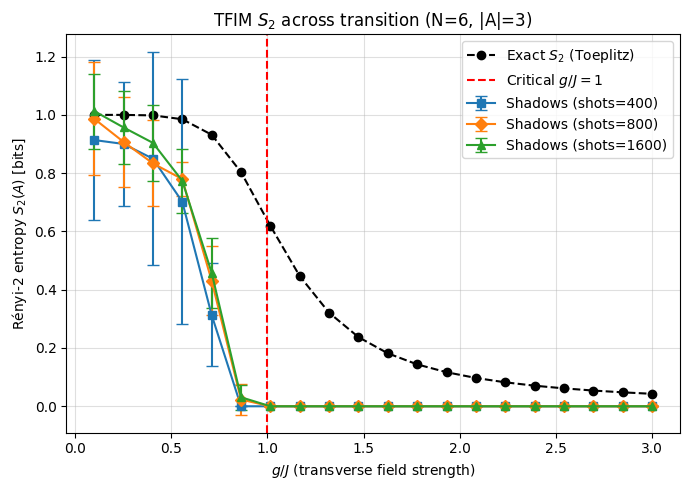

In [27]:
# ==== Sweep over g: Exact (Toeplitz) vs Shadows with multiple shots ====

# Params
N = 6
J = 1.0
g_list   = np.linspace(0.1, 3.0, 20)
L        = N // 2                 # block length
keep     = list(range(L))         # contiguous block [0..L-1]
shots_list = [400, 800, 1600]      # compare these shot counts
n_trials = 5                      # repeats for error bars

# --- Exact once ---
S2_exact_list = [estimate_S2(N, J, g, L=L, method="toeplitz") for g in g_list]

# --- Plot ---
plt.figure(figsize=(7,5))
plt.plot(g_list, S2_exact_list, 'k--o', label="Exact $S_2$ (Toeplitz)")

marker_cycle = ['s', 'D', '^']  # square, diamond, triangle
for shots, mk in zip(shots_list, marker_cycle):
    means, stds = [], []
    for g in g_list:
        # ground state vector (diagonalize ONCE per g)
        Ham = tfim_hamiltonian(N, J=J, g=g, periodic=True)
        evals, evecs = np.linalg.eigh(Ham)
        psi0 = evecs[:, np.argmin(evals)]

        # repeat a few trials for error bars
        vals = []
        for t in range(n_trials):
            rng = np.random.default_rng(1234 + t)
            S2_est = estimate_S2_from_psi(psi0, keep=keep, shots=shots, rng=rng)
            vals.append(S2_est)
        means.append(np.mean(vals))
        stds.append(np.std(vals, ddof=1))

    plt.errorbar(g_list, means, yerr=stds, fmt=f'{mk}-', capsize=4,
                 label=f"Shadows (shots={shots})")

plt.axvline(1.0, color='r', ls='--', label="Critical $g/J=1$")
plt.xlabel("$g/J$ (transverse field strength)")
plt.ylabel("Rényi-2 entropy $S_2(A)$ [bits]")
plt.title(f"TFIM $S_2$ across transition (N={N}, |A|={L})")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

### Derandomization

## Derandomized Classical Shadows

In the standard classical shadow protocol (Huang–Kueng–Preskill, *Nat. Phys.* 2020),  
each qubit is measured in a Pauli basis chosen **independently at random** from  
\(\{X, Y, Z\}\). This ensures unbiasedness but leads to large variance when the  
number of shots is limited.

A useful refinement is **derandomization**: instead of sampling bases randomly,  
we construct a **deterministic schedule** so that each qubit sees \(X, Y, Z\) in  
a balanced way across all shots. This preserves the unbiasedness of the purity  
estimator while **reducing variance**, since the sampling error from unlucky  
basis choices is eliminated.

Two simple schedules we demonstrate here are:

- **Latin-cycle schedule**: cycle each qubit through \(X \to Y \to Z\).  
- **Base-3 counter schedule**: assign bases by counting in base-3 with offsets,  
  so that all Pauli settings are covered evenly.

Formally, the estimator remains the same:

$$
\hat p \;=\; \frac{1}{\binom{m}{2}} \sum_{i<j} \mathrm{Tr}\!\left(\hat\rho_A^{(i)} \hat\rho_A^{(j)}\right),
$$

and the Rényi-2 entropy is recovered via

$$
S_2(A) \;=\; -\log_2 \hat p .
$$

By derandomizing the choice of Pauli bases, the variance of \(\hat p\) is  
significantly reduced compared to i.i.d. random sampling.

The code below implements helper routines for deterministic Pauli schedules  
and integrates them into the shadow estimator. We will later compare  
**random vs. derandomized** shadows to highlight the variance reduction.

In [22]:
# ==== Derandomized Classical Shadows Demo ====
#
# In the original shadow experiments we sampled Pauli bases i.i.d. at random.
# However, as noted in Huang–Kueng–Preskill (2020), one can DERANDOMIZE the
# basis choice so that each qubit sees {X,Y,Z} in a balanced, deterministic way.
# This preserves unbiasedness but typically lowers the variance of estimators.

# --- small helpers for deterministic Pauli schedules ---
def _ternary_digits(n, width):
    digs = []
    while n > 0:
        n, r = divmod(n, 3)
        digs.append(r)
    while len(digs) < width:
        digs.append(0)
    return digs[:width]

def derand_pauli_schedule(shots, N, mode="base3"):
    """
    Return an array of shape (shots, N) with entries in {'X','Y','Z'}.
    - 'latin': very light-weight Latin-cycle schedule
    - 'base3': base-3 counter across shots with small offsets
    """
    bases = np.empty((shots, N), dtype='<U1')
    if mode == "latin":
        pattern = np.array(list("XYZ"))
        for s in range(shots):
            for q in range(N):
                bases[s, q] = pattern[(s + q) % 3]
        return bases

    # default: 'base3'
    for s in range(shots):
        digs = _ternary_digits(s, N)
        for q in range(N):
            v = (digs[q] + q + (s // 3)) % 3
            bases[s, q] = "XYZ"[v]
    return bases

# --- variant of shadow estimator with schedule control ---
def estimate_S2_from_psi(psi, keep, shots=1000, rng=None,
                         schedule="random", schedule_mode="base3"):
    rng = np.random.default_rng() if rng is None else rng
    N = int(np.log2(psi.size))
    opsA = []

    if schedule == "derand":
        base_seq = derand_pauli_schedule(shots, N, mode=schedule_mode)
        for s in range(shots):
            bases = base_seq[s]
            bits  = sample_outcome_bits_from_psi(psi, bases, rng)
            ops_keep = [one_qubit_shadow_estimator(bases[q], int(bits[q])) for q in keep]
            opsA.append(kron_n(ops_keep))
    else:
        for _ in range(shots):
            bases = rng.choice(np.array(['X','Y','Z']), size=N)
            bits  = sample_outcome_bits_from_psi(psi, bases, rng)
            ops_keep = [one_qubit_shadow_estimator(bases[q], int(bits[q])) for q in keep]
            opsA.append(kron_n(ops_keep))

    # cross-term purity
    acc, cnt = 0.0, 0
    for i, j in combinations(range(len(opsA)), 2):
        acc += np.trace(opsA[i] @ opsA[j]).real
        cnt += 1
    pur = acc/cnt if cnt > 0 else np.nan
    pur = float(np.clip(pur, 1e-12, 1.0 - 1e-9))
    return -np.log2(pur)

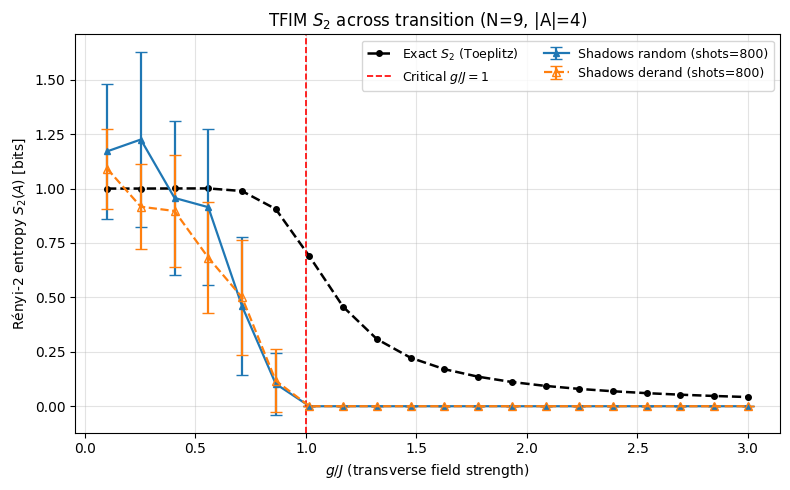

In [28]:
# ==== Sweep over g: Exact vs Shadows (random vs derandomized, 3 shot counts) ====

# Params
N = 9
J = 1.0
g_list    = np.linspace(0.1, 3.0, 20)
L         = N // 2
keep      = list(range(L))
shots_list = [800]
n_trials  = 10

# --- exact once (Toeplitz) ---
S2_exact_list = [estimate_S2(N, J, g, L=L, method="toeplitz") for g in g_list]

# --- ground states per g (diagonalize only once per g) ---
psi_per_g = []
for g in g_list:
    Ham = tfim_hamiltonian(N, J=J, g=g, periodic=True)
    evals, evecs = np.linalg.eigh(Ham)
    psi_per_g.append(evecs[:, np.argmin(evals)])

def shadow_curve(psi_list, schedule, shots, n_trials):
    means, stds = [], []
    for psi0 in psi_list:
        vals = []
        for t in range(n_trials):
            rng = np.random.default_rng(1234 + t)
            # NOTE: estimate_S2_from_psi needs to accept schedule="random"/"derand"
            v = estimate_S2_from_psi(psi0, keep=keep, shots=shots, rng=rng,
                                     schedule=schedule, schedule_mode="base3")
            vals.append(v)
        means.append(np.mean(vals))
        stds.append(np.std(vals, ddof=1))
    return np.array(means), np.array(stds)

# --- build curves for random vs derand for each shots ---
curves = {}
for shots in shots_list:
    curves[("random", shots)] = shadow_curve(psi_per_g, "random",  shots, n_trials)
    curves[("derand", shots)] = shadow_curve(psi_per_g, "derand",  shots, n_trials)

# --- plot ---
plt.figure(figsize=(8,5))
# exact
plt.plot(g_list, S2_exact_list, 'k--o', lw=1.8, ms=4, label=r"Exact $S_2$ (Toeplitz)")

# style helpers
markers = {400:'s', 600:'D', 800:'^'}  # square, diamond, triangle

for shots in shots_list:
    # random: solid filled markers
    mean_r, std_r = curves[("random", shots)]
    plt.errorbar(g_list, mean_r, yerr=std_r,
                 fmt=markers[shots]+'-', capsize=4, lw=1.6, ms=5,
                 label=f"Shadows random (shots={shots})")

    # derand: dashed, hollow markers (same shape/color as random)
    mean_d, std_d = curves[("derand", shots)]
    plt.errorbar(g_list, mean_d, yerr=std_d,
                 fmt=markers[shots]+'--', mfc='none', capsize=4, lw=1.6, ms=6,
                 label=f"Shadows derand (shots={shots})")

plt.axvline(1.0, color='r', ls='--', lw=1.2, label=r"Critical $g/J=1$")
plt.xlabel(r"$g/J$ (transverse field strength)")
plt.ylabel(r"Rényi-2 entropy $S_2(A)$ [bits]")
plt.title(fr"TFIM $S_2$ across transition (N={N}, |A|={L})")
plt.grid(True, alpha=0.35)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()